In [1]:
from sdapy import ztfanalysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
ztfp = ztfanalysis.ztfsingle(ztfid='ZTF21abaiono', iauid='SN 2021lwz', 
                 z=0.065, dm=37.29, mkwebv=0, sntype='SN Ic')
ztfp.config_ztfquery(wdir='/Users/yash0613/Desktop/scripts/sn_data_analysis/sdapy')
#ztfp.query_alert_ztf(source='fritz')
ztfp.get_alert_ztf(source='fritz')
ZTF21abaiono_fritz = ztfp.lc.query('instrument_name in ["IOO", "SEDM"]')

#ztfp.query_spectra(source='fritz')

In [3]:
#ZTF21abaiono_fritz.query('filter=="g"')

In [4]:
ZTF21abaiono_uv=pd.read_csv('/Users/yash0613/Desktop/scripts/sn_data_analysis/data/ZTF21abaiono_uv.csv',
                            sep='\s*&\s*',).drop_duplicates()
ZTF21abaiono_uv['jdobs'] = ZTF21abaiono_uv['MJD'] + 2400000.5
fs=[]
for _ in ZTF21abaiono_uv.index:
    f = ZTF21abaiono_uv['filter'][_]
    if f == 'uvw1': fs.append('A')
    elif f == 'uvm2': fs.append('D')
    elif f == 'uvw2': fs.append('S')
    elif f == 'u': fs.append('U')
    elif f == 'b': fs.append('B')
    elif f == 'v': fs.append('V')
ZTF21abaiono_uv['filter'] = fs

generate /Users/yash0613/Library/CloudStorage/Box-Box/ztf_data/tmp//Arnett1_ZTF21abaiono_trf_3.npz


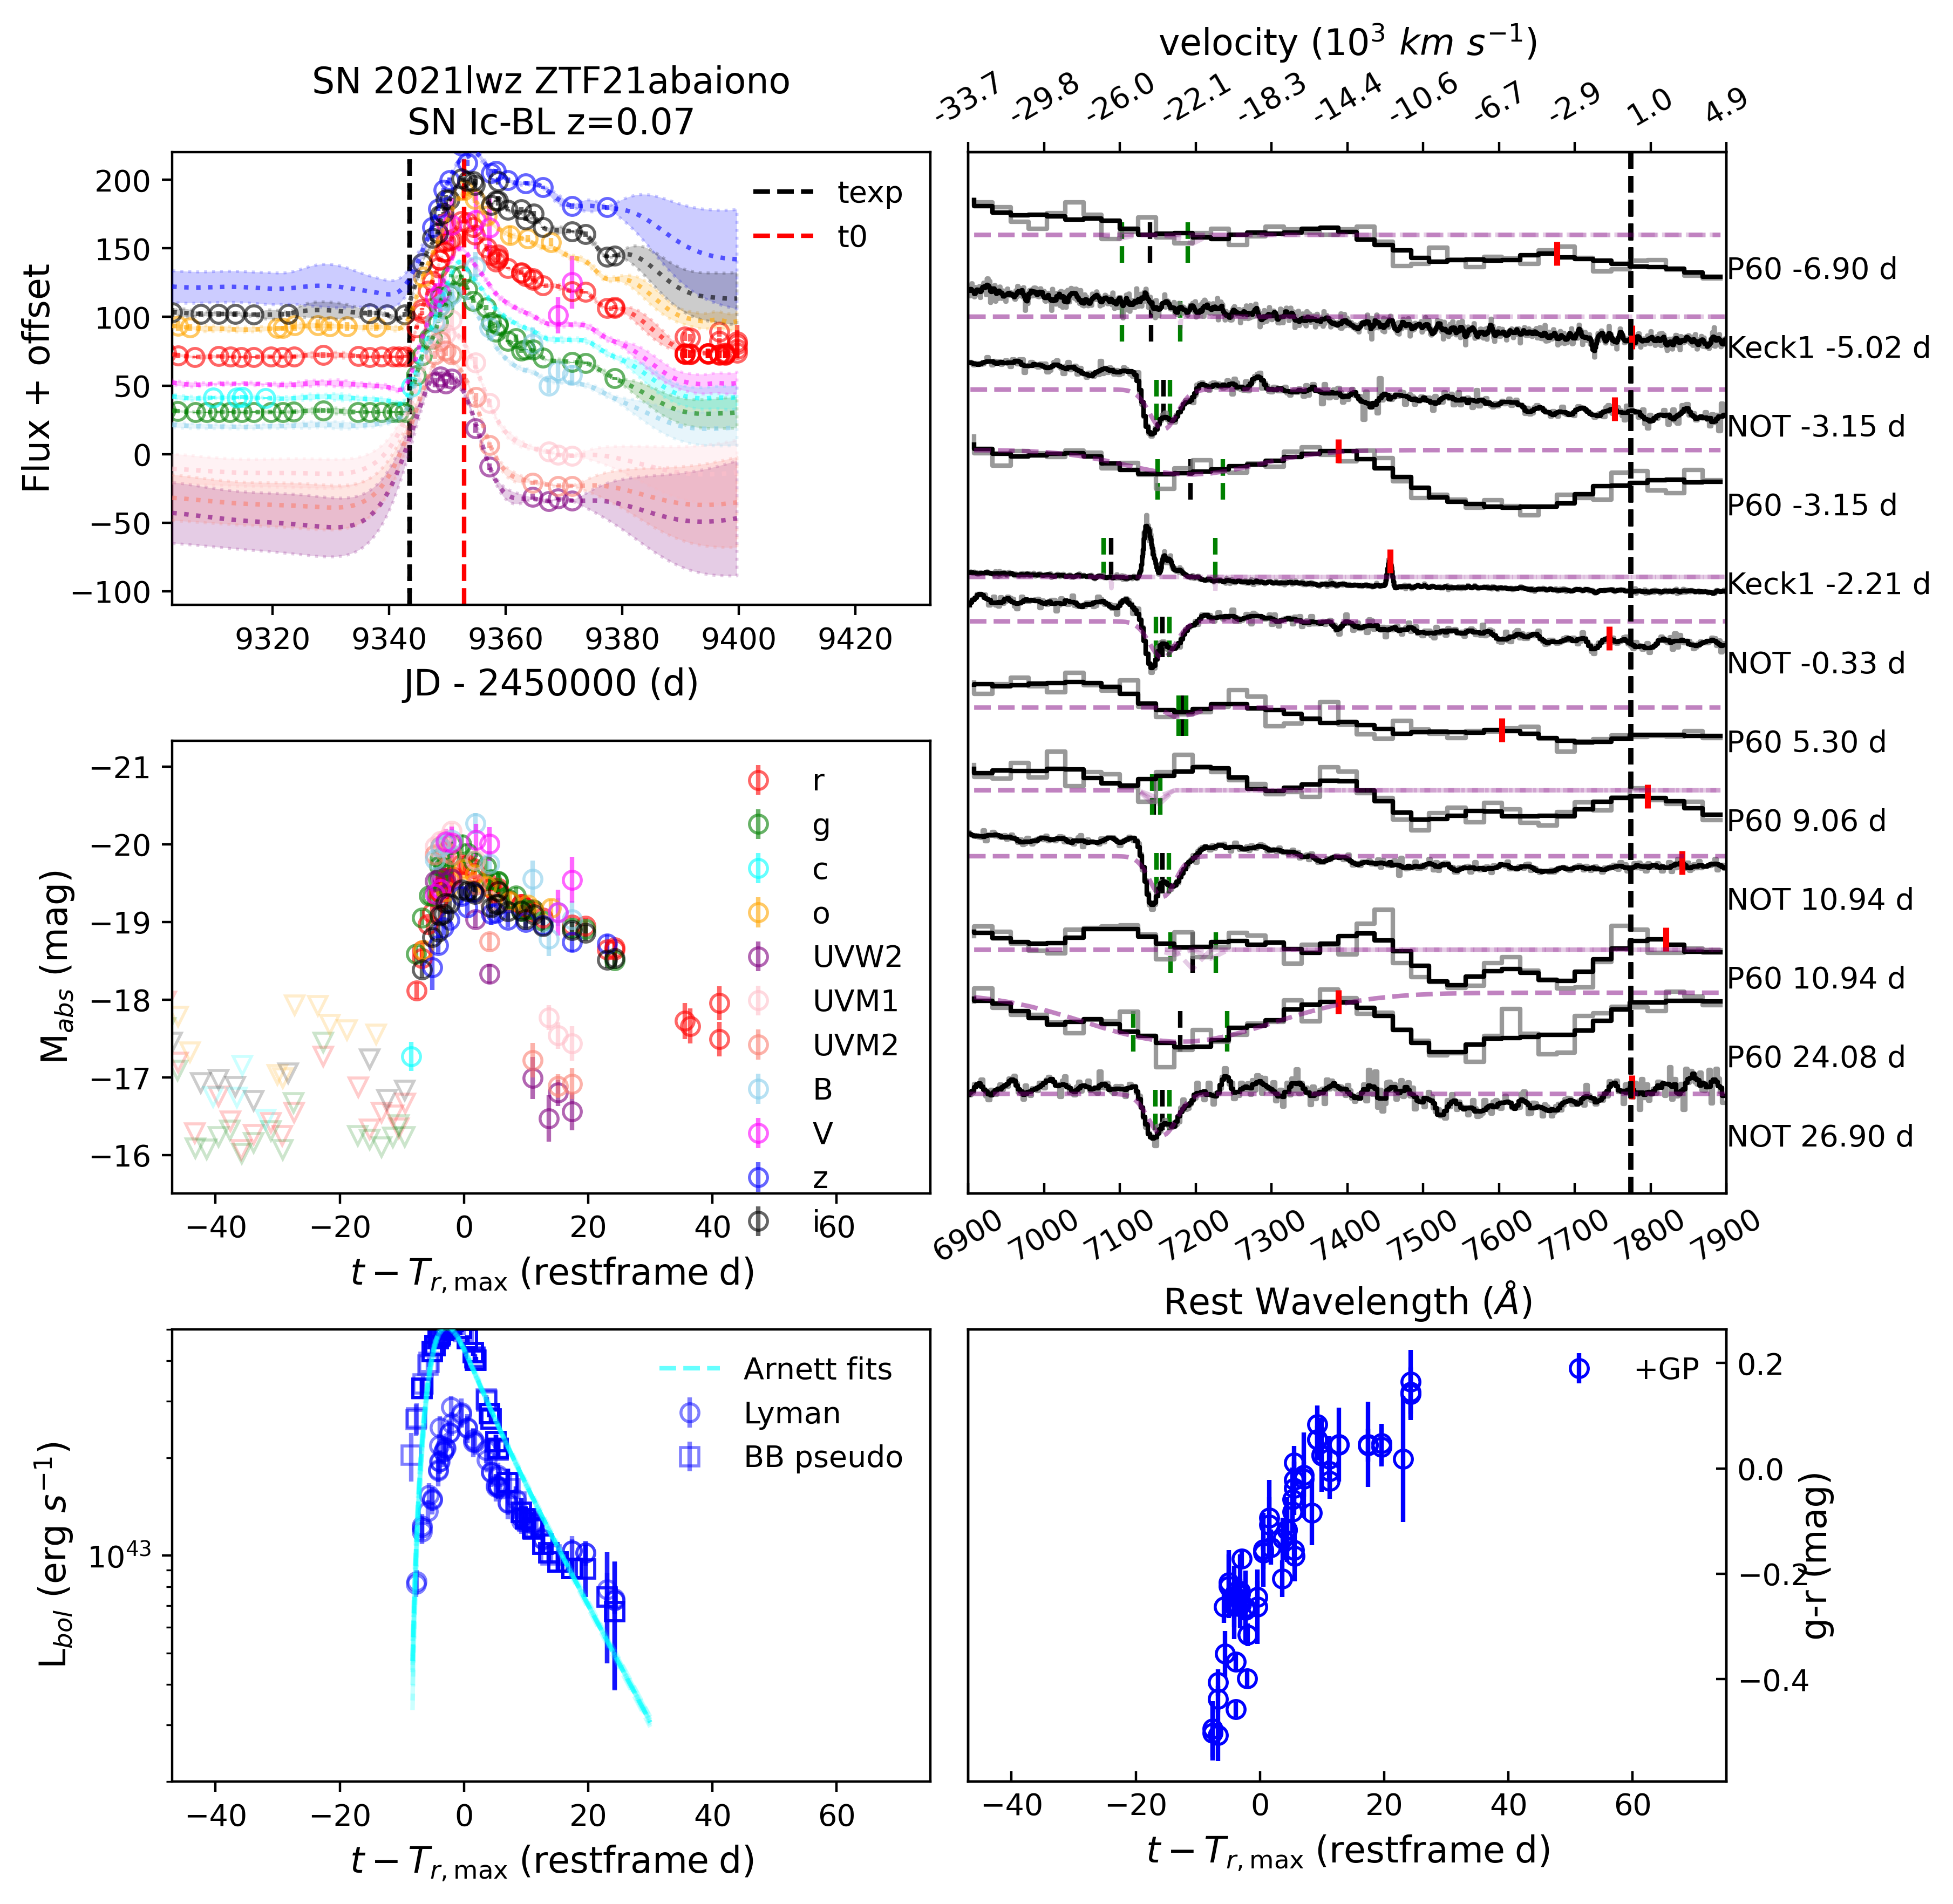

In [5]:
par = {
    'plot_bands': ['r','g','c','o','S','A','D','B','V','z','i'],
    'jdmin': 2459250,
    'jdmax': 2459400,
    'gp_bands': ['r','g','c','o','S','A','D','B','V','z','i'],
    'pl_type':0,
    'pl_bands': ['g'],
    'nsteps': 40000,
    'nsteps_burnin': 20000,
    'verbose': True,
    'rel_flux_cutoff': .8,
    #'nwalkers':50,
    'ax_xlim': [-50,80],
    'ax_ylim': [-110,220],
    'ax4_ylim': [2e42,5e43],
    'bolopt': [1,2],
    'cfilters': ['r','g','c','o','S','A','D','B','V'],
    'bb_copt': [2,3],
    'lyman_copt': [2,3],
    'copt': [2,3],
    'Arnett_fitr': [-10,30],
    'Arnett_plotr': [-10,30],
    'Arnett_copt': [2,3],
    'Arnett_bolopt': 2,
    'Arnett_type': 2,
    'Arnett_routine': 'trf',
    'Arnett_style': 3,
    'spec_source': ['TNS'],
    'spec_fitr'    : [20000, 26000],
    'spec_plotr'   : [20000, 26000],
    'spec_type'    : 2,
    'tm_pl'       : 50
}
ztfp = ztfanalysis.ztfsingle(ztfid='ZTF21abaiono', iauid='SN 2021lwz', 
                 z=0.065, dm=37.29, mkwebv=0.014, sntype='SN Ic-BL', **par)
ztfp.get_fp_ztf()
ztfp.get_fp_atlas(binDays=1, clobber=False, verbose=True)
ztfp.add_lc(ZTF21abaiono_uv,source='swift')
ztfp.add_flux(source='swift')
ztfp.add_lc(ZTF21abaiono_fritz,source='fritz')

ztfp.on_sntype() # check sn type   
ztfp.run_gp()     # Gaussian process
ztfp.set_t0_withgp() 
ztfp.set_texp_midway()

if False:
    fig,ax=plt.subplots(1,1)
    ztfp.calibrate_baseline(ax=ax, key='fcqfid', source='ztffp',
                    xmin=-100, xmax=-20, ax_xlim=None, ax_ylim=None)
else:
    ztfp.init_fig()
    ztfp.explosion_pl(ext_filt=['g',], ext_num=10)
    ztfp.calc_colors()  # g-r colour epochs
    ztfp.lyman_bol()  # calculate luminosity from g,r with Lyman bol correction
    ztfp.bb_colors()
    ztfp.bb_bol()
    ztfp.get_local_spectra() 
    ztfp.meas_specline()

    ztfp.arnett_fit() # fit lums around peak to arnett model
    ztfp.plot()   # plot everything

In [42]:
data=dict()
for _ in ztfp.lc.index:
    source = ztfp.lc['source'][_]
    mag = ztfp.lc['mag'][_]
    emag = ztfp.lc['emag'][_]
    limmag = ztfp.lc['limmag'][_]
    flux = ztfp.lc['flux'][_]
    eflux = ztfp.lc['eflux'][_]
    filt = ztfp.lc['filter'][_]
    if source =='swift': 
        mjd = ztfp.lc['MJD'][_]
        inst = 'UVOT'
        if filt == 'A': filt='uvw1'
        elif filt == 'D': filt='uvm2'
        elif filt == 'S': filt='uvw2'    
    elif source == 'ztffp': 
        mjd = ztfp.lc['jdobs'][_] - 2400000.5
        inst = 'P48'
    elif source == 'atlasfp': 
        mjd = ztfp.lc['MJD'][_]
        inst = 'ATLAS'
    elif source == 'fritz': 
        mjd = ztfp.lc['mjd'][_]
        inst = ztfp.lc['instrument_name'][_]
    else:
        print (_)
    data[mjd] = '%.2f & %s & %.2f & %.2f & %.2f & %s \\\\' % (mjd, filt, mag, emag, limmag, inst)
#for _ in sorted(data):
#    print (data[_])

Text(0.5, 0, '$t - T_{r,\\mathrm{max}} \\; (\\mathrm{restframe \\; d})$')

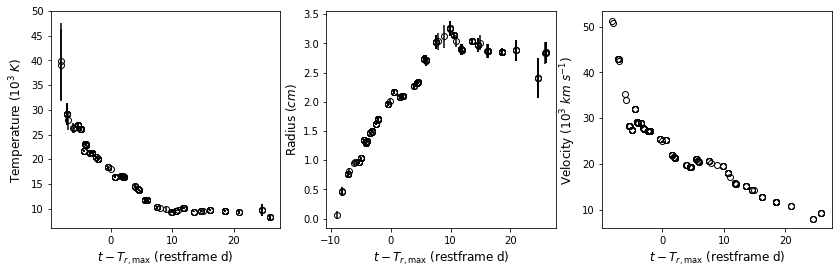

In [104]:
fig,(ax,ax1,ax2)=plt.subplots(1,3,figsize=(14,4))
t0 = ztfp.t0
__=np.argmin(ztfp.mbolbb[3][0])
__=np.where(ztfp.mbolbb[3][0]>ztfp.mbolbb[3][0][__])
ax.errorbar(np.array(ztfp.mbolbb[3][0])[__]-t0,
            np.array(ztfp.mbolbb[3][3])[__],
            yerr=np.array(ztfp.mbolbb[3][4])[__],color='k',marker='o',ls='',fillstyle='none')
ax1.errorbar(ztfp.mbolbb[3][0]-t0,ztfp.mbolbb[3][5],yerr=ztfp.mbolbb[3][6],color='k',marker='o',ls='',fillstyle='none')
__=np.argmin(ztfp.mbolbb[3][0])
ax2.plot(ztfp.mbolbb[3][0]-t0,(ztfp.mbolbb[3][5]-ztfp.mbolbb[3][5][__])/(ztfp.mbolbb[3][0]-ztfp.mbolbb[3][0][__])*1e7/86400,
             color='k',marker='o',ls='',fillstyle='none')
ax.set_ylim([6,50])
ax.set_ylabel('Temperature ($10^{3}~K$)', fontsize=12)
ax1.set_ylabel('Radius ($cm$)', fontsize=12)
ax2.set_ylabel('Velocity ($10^{3}~km~s^{-1}$)', fontsize=12)
ax.set_xlabel('$t - T_{r,\mathrm{max}} \; (\mathrm{restframe \; d})$',fontsize=12)
ax1.set_xlabel('$t - T_{r,\mathrm{max}} \; (\mathrm{restframe \; d})$',fontsize=12)
ax2.set_xlabel('$t - T_{r,\mathrm{max}} \; (\mathrm{restframe \; d})$',fontsize=12)

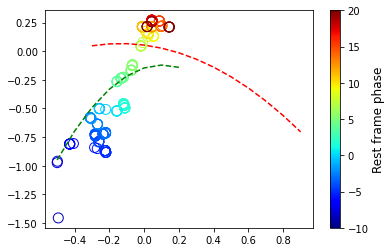

In [57]:
from sdapy import functions,filters,models
fig,ax=plt.subplots(1,1,figsize=(6,4))
t0 = ztfp.t0
for _t, mg, mr in zip(ztfp.cbb[3]['t'], ztfp.cbb[3]['g'][0], ztfp.cbb[3]['r'][0]):
    __ = np.where(np.array(ztfp.mbolbb[3][0]) == _t)
    mbol = functions.Lbol_to_Mbol(np.array(ztfp.mbolbb[3][1])[__])
    if len(mbol) == 0:continue
    Mg = mg-ztfp.dm-(ztfp.mkwebv+ztfp.hostebv) * filters.Rf['g']
    Mr = mr-ztfp.dm-(ztfp.mkwebv+ztfp.hostebv) * filters.Rf['r']
    bcg = mbol[0] - Mg
    phase = (_t - t0)/(1+ztfp.z)
    sc=ax.scatter(Mg-Mr, bcg, marker='o', c=phase, vmin=-10, vmax=20, 
                s=100, cmap=plt.cm.jet)
    sc.set_facecolor('none')

cbar=fig.colorbar(sc, ax=ax)
cbar.ax.set_ylabel('Rest frame phase',fontsize=12)
xx = np.arange(-.3,1,.1)
yy = models.BC_Lyman(xx, phase=1, sntype=1)
ax.plot(xx, yy[0], 'r--')
xx = np.arange(-.5,.3,.1)
yy = models.BC_Lyman(xx, phase=2, sntype=1)
ax.plot(xx, yy[0], 'g--')

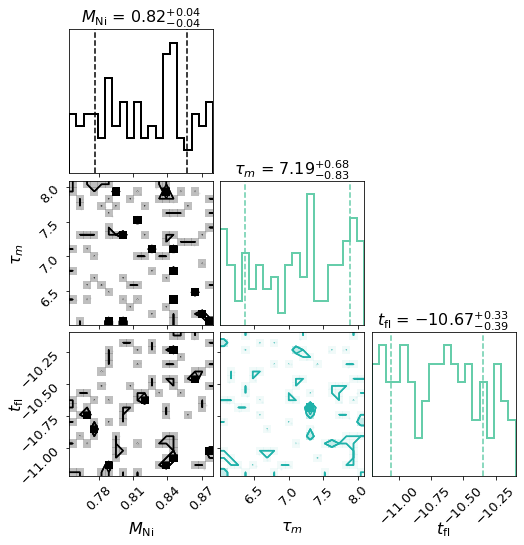

In [4]:
ztfp.corner(which='arnett_fitt')

In [26]:
ztfp.arnettcls.get_par()

([1.1288221685338728, 4.319800475673998, -8.99794182696501],
 [1.1376420285348194, 4.419068252111405, -8.881666914158892],
 [1.1463264606560932, 4.51730575414496, -8.753655918041241])

In [28]:
from sdapy.models import taum_to_Mej_Ek
#taum_to_Mej_Ek(8.55, 30, taumerr=None, vejerr=None)
taum_to_Mej_Ek(4.48, 50, taumerr=None, vejerr=None)

(1.437856067533596, 35.74869647905405)

In [18]:
ztfp.fig.savefig('/Users/yash0613/Desktop/2021lwz.png', dpi=400, bbox_inches='tight')

In [37]:
from collections import OrderedDict
import json, requests
search_obj          = [("ra", ""), ("dec", ""), ("radius", ""), ("units", ""), ("objname", "1998bw"), 
                       ("objname_exact_match", 0), ("internal_name", ""), 
                       ("internal_name_exact_match", 0), ("objid", ""), ("public_timestamp", "")]
get_obj             = [("objname", "1987a"), ("objid", ""), ("photometry", "1"), ("spectra", "1")]
tns_botid = 131335
tns_botname = "kinder_bot"
tns_api = '02c3e6e17237a7fc5ad9825a53cc61f0db360aa4'
TNS         = "sandbox.wis-tns.org"
url_tns_api = "https://" + TNS + "/api/get"
#search_url  = url_tns_api + "/search"
#tns_marker = 'tns_marker{"tns_id": "' + str(tns_botid) + '", "type": "bot", "name": "' + tns_botname + '"}'        
#headers = {'User-Agent': tns_marker}
#json_file = OrderedDict(search_obj)
#search_data = {'api_key': tns_api, 'data': json.dumps(json_file)}
#response = requests.post(search_url, headers = headers, data = search_data)
#parsed = json.loads(response.text, object_pairs_hook = OrderedDict)
#result = json.dumps(parsed, indent = 4)

get_url = url_tns_api + "/object"
tns_marker = 'tns_marker{"tns_id": "' + str(tns_botid) + '", "type": "bot", "name": "' + tns_botname + '"}'
headers = {'User-Agent': tns_marker}
json_file = OrderedDict(get_obj)
get_data = {'api_key': tns_api, 'data': json.dumps(json_file)}
response = requests.post(get_url, headers = headers, data = get_data)
#parsed = json.loads(response.text, object_pairs_hook = OrderedDict)
#result = json.dumps(parsed, indent = 4)
print (response.text)


{"id_code":401,"id_message":"Unauthorized"}
